All the imports

In [3]:
from abc import ABC

import pandas as pd
import numpy as np

import torch as t
from torch.utils.data import Dataset, DataLoader, random_split

import nltk
from nltk.tokenize import TweetTokenizer
from nltk import TweetTokenizer
from nltk.corpus import stopwords

import gensim.downloader as api

from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns

from collections import Counter

from typing import Union

/Users/elviramoberg/IdeaProjects/Applied_ML/new_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'matplotlib'

### Loading the raw data

In [1]:
def get_transformed_dataframe(path: str):
    """
    Takes the path to the tsv file of this assignment and transforms the dataframe so that only one label is present. 
    
    Returns the new dataframe.
    """
    df = pd.read_csv(path, sep="\t", names=["target", "text"])
    Y_raw = np.array(df["target"].values)

    target_list = [list(map(int, label.split("/"))) for label in Y_raw]
    df["target"] = target_list

    finalized_df = pd.DataFrame(columns=["target", "text"])
    for _, row in df.iterrows():
        if row["target"].count(-1) >= 1 or np.mean(row["target"]) == 0.5:
            continue
        else: 
            if np.mean((row["target"])) < 0.5:
                row["target"] = int(0)
            elif np.mean((row["target"])) > 0.5:
                row["target"] = int(1)
            else:
                continue
            finalized_df = pd.concat([finalized_df, pd.DataFrame([row])], ignore_index=True)

    finalized_df["target"] = finalized_df["target"].astype(int)
    return finalized_df

### Exploring the reliability of the data

In [2]:
df = pd.read_csv('a3_train_final.tsv', sep="\t", names=["target", "text"])
Y_raw = np.array(df["target"].values)
target_list = [list(map(int, label.split("/"))) for label in Y_raw]

# Analysing the distribution of datapoints in training data
unknown_annotation = 0
contradicting_annotations  = 0
agreeing_annotations = 0
for target in target_list:
    if -1 in target:
        unknown_annotation +=1 
    elif len(set(target)) == 1:
        agreeing_annotations +=1
    else: 
        contradicting_annotations += 1 


# Plot distribution of datapoints 
values = [unknown_annotation, agreeing_annotations, contradicting_annotations]
categories = ["Unknown Annotation", "Majority Agreement", "Contradicting Annotations"]
colors = ["grey", "lightgreen", "grey"]
percentages = [unknown_annotation/len(target_list)*100, agreeing_annotations/len(target_list)*100, contradicting_annotations/len(target_list)*100]
print(f"Percentage of unknown annotation, percentage of agreeing annotations, percentage of contradicting annotations : {percentages}")

plt.bar(categories, values, width=0.6)
plt.ylabel("Quantity", fontsize=8)
plt.title("Distribution of annotations", fontsize=14)
plt.show()

NameError: name 'pd' is not defined

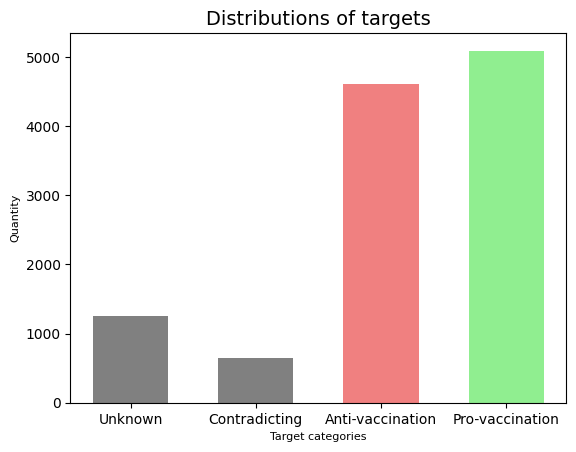

In [ ]:
unknown_target = 0
contradicting_target  = 0
target_0 = 0
target_1 = 0
for target in target_list:
    if -1 in target:
        unknown_target +=1 
    elif np.mean(target) == 0.5:
        contradicting_target +=1 
    elif np.mean((target)) < 0.5:
            target_0 +=1
    else: 
        target_1 +=1

 
#plot distribution of datapoints 
values = [unknown_target, contradicting_target, target_0, target_1]
categories = ["Unknown", "Contradicting", "Anti-vaccination", "Pro-vaccination"]
colors = ["grey", "grey", "lightcoral", "lightgreen"]

plt.bar(categories, values, color=colors, width=0.6)
plt.xlabel("Target categories", fontsize=8)
plt.ylabel("Quantity", fontsize=8)
plt.title("Distributions of targets", fontsize=14)
plt.show()

### Doing some exploratory data analysis

Specically looking at relative word counts, so if a certain word mainly appears in one of the two types of comments that is something we want to know. This knowledge will be useful when discussing the errors made by the model.

[['Billions', 'have', 'been', 'vaccinated,', 'and', 'the', 'vast', 'majority', 'are', 'fine.', 'That’s', 'not', 'a', 'conspiracy;', 'that’s', 'just', 'facts.'], ['CDC', 'recommends', 'everyone', 'ages', '6', 'months', 'and', 'older', 'receive', 'an', 'updated', '2024-2025', 'COVID-19', 'vaccine', 'to', 'protect', 'against', 'the', 'potentially', 'serious', 'outcomes', 'of', 'COVID-19', 'this', 'fall', 'and', 'winter', 'whether', 'or', 'not', 'they', 'have', 'ever', 'previously', 'been', 'vaccinated', 'with', 'a', 'COVID-19', 'vaccine....', 'https://www.cdc.gov/media/releases/2024/s-t0627-vaccine-recommendations.html'], ['COVID', 'is', 'way', 'riskier', 'than', 'any', 'rare', 'vaccine', 'side', 'effect.', 'It’s', 'all', 'about', 'risk', 'vs.', 'benefit.'], ["Don't", 'tell', 'me', 'what', 'to', 'do', 'with', 'my', 'body', '-', 'the', 'same', 'people', 'that', 'want', 'to', 'enforce', 'anti-abortion', 'laws', 'on', 'women.'], ['Funny', 'how', 'people', 'trust', 'fast', 'food', 'and', 'ene

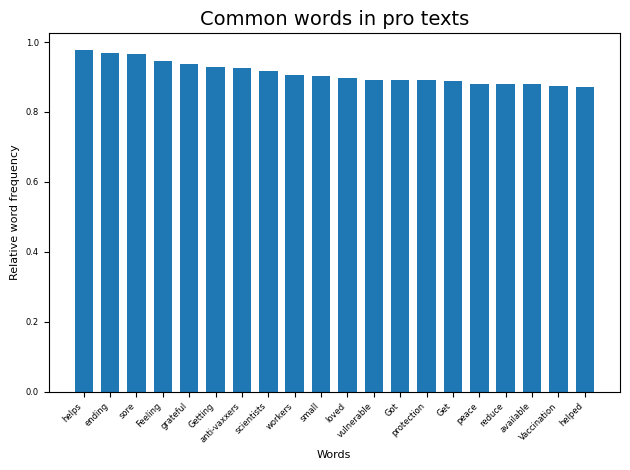

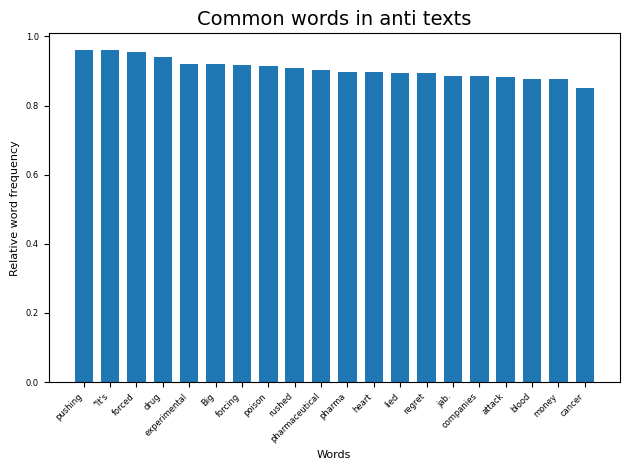

In [ ]:

finalized_df = get_transformed_dataframe('a3_train_final.tsv')

#analyze common words in anti and pro texts
#sort anti vaccine texts and pro vaccine texts
pro_vaccine_array = np.array(finalized_df[finalized_df["target"] == 1]["text"])
pro_vaccine_array = [line.split() for line in pro_vaccine_array]
print(pro_vaccine_array)
anti_vaccine_array = np.array(finalized_df[finalized_df["target"] == 0]["text"])
anti_vaccine_array = [line.split() for line in anti_vaccine_array]
total_array = np.array(finalized_df["text"])
total_array = [line.split() for line in total_array]

#count number of word occurances using counter from collections, first flatten array with concatenate 
count_pro_words = Counter(np.concatenate(pro_vaccine_array))
count_anti_words = Counter(np.concatenate(anti_vaccine_array))
count_total_words = Counter(np.concatenate(total_array))

#makes a dictionary of words and relative times it occurs in all texts vs in anti/pro text 
#only looking at words with frequency above 30 since words that only occur a few times are not as interesting
relative_occurances_pro = {word: count / count_total_words[word] for word, count in count_pro_words.items() if count>30}
relative_occurances_anti = {word: count / count_total_words[word] for word, count in count_anti_words.items() if count>30}

#find 20 most common anti and pro words
sorted_pro = [(key, relative_occurances_pro[key]) for key in relative_occurances_pro.keys()]
most_common_pro = sorted(sorted_pro, key=lambda x: -x[1])[:20]

sorted_anti = [(key, relative_occurances_anti[key]) for key in relative_occurances_anti.keys()]
most_common_anti = sorted(sorted_anti, key=lambda x: -x[1])[:20]

occurances_pro = [quantity for _, quantity in most_common_pro]
words_pro = [word for word, _ in most_common_pro]

occurances_anti = [quantity for _, quantity in most_common_anti]
words_anti = [word for word, _ in most_common_anti]

plt.bar(words_pro, occurances_pro, width=0.7)
plt.xlabel("Words", fontsize=8)
plt.ylabel("Relative word frequency", fontsize=8)
plt.title("Common words in pro texts", fontsize=14)
plt.yticks(fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

plt.bar(words_anti, occurances_anti, width=0.7)
plt.xlabel("Words", fontsize=8)
plt.ylabel("Relative word frequency", fontsize=8)
plt.title("Common words in anti texts", fontsize=14)
plt.yticks(fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

# Preprocessing

This first class is a Preprocessor Class that will preprocess the data. It starts with tokenizing the data into lists of words. Then common words which hold little value, *stopwords* are removed and stemming is applied. Stemming is the process of transforming a word to its base form, for example: running -> run.

After that, embeddings for the lists of words have to be created to be bale to distinghuish between different kinds of words. The words have to be represented as vectors for the model later. Since all of these vectors must have the same size, padding in the form of 0:s are added at the beginning of each vector so that all of them will have the same size.

In [ ]:

class PreprocessorClass(ABC):
    """
    Abstract Class for preprocessing the data.
    """
    
    def __init__(self, subclass, vector_size):
        self._weights = subclass
        self._loaded    = False
        self.vector_size = vector_size
    
    def __getitem__(self, data: np.ndarray) -> t.Tensor:
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        stemmer = nltk.stem.PorterStemmer()

        tokenizer = TweetTokenizer()
       
        def clean_text(text):
            """
            Removes stopwords and applies stemming.
            """
            no_stop_words = [w for w in text if not w.lower() in stop_words]
            cleaned_text = [stemmer.stem(w) for w in no_stop_words]
            return cleaned_text
        
        # Tokenize and prepare the words
        tokenized_data = [clean_text(tokenizer.tokenize(text))[:512] for text in data]

        # First find the largest vector, all must be the size, add padding of 0:s at the beginning
        largest = 0
        for i in range(len(data)):
            largest = max(largest, len(tokenized_data[i]))
        
        embeddings_tensor = t.empty(len(data), largest, self.vector_size)
        for i in range(len(data)):
            line = tokenized_data[i]
            embedded_line = t.zeros(largest, self.vector_size)
            for j, word in enumerate(line):
                if word in self._weights:
                    embedded_line[largest - len(line) + j] = t.tensor(self._weights[word], dtype=t.float16)
                
            embeddings_tensor[i] = embedded_line
        
        return embeddings_tensor

class Twitter50EmbeddingPreprocessor(PreprocessorClass):
    """
    Preprocesses data and generates embeddings with the Glove-twitter-50 pretrained model.
    """
    def __init__(
        self
    ):
        super().__init__(Twitter50EmbeddingPreprocessor, 50)
        
        if not(self._loaded):
            print("Embedding Weights not loaded. Loading weights ...")
            self._weights = api.load('glove-twitter-50')
            print("Finished loading weights.")


### Embedding Models

In [ ]:

def bert_transform(text_list, batch_size=8):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    tokenizer: BertTokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenizer.padding_side = "left"
    model: BertModel = BertModel.from_pretrained("bert-base-uncased")
    stemmer = nltk.stem.PorterStemmer()

    def remove_stop_words(text: str): # Not used since decreased performance
        return " ".join([w for w in text.split() if w.lower() not in stop_words])
    
    def stem_words(text: str): # Not used since decreased performance
        return " ".join([stemmer.stem(w) for w in text.split()])

    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with t.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1))
    return t.cat(embeddings)

def get_preprocessed_X_twitter_glove_50(X_text):
    embedding_model = Twitter50EmbeddingPreprocessor()
    X = embedding_model[X_text]
    return X


### Models

In [ ]:

class TransformerClassifier(t.nn.Module):
    """
    Our implementation of a Transformers based classifier. Takes 5 parameters, where 3 of them are optional.
    Args:
        input_dim: The dimension of the input data.
        hidden_dim: The hidden dinemsion of the transformer layers and fully connected layers.
        n_layers: Number of transformer encoder layers. Defualt value is 2.
        n_heads: Number of attention heads of the model. Defualt value is 1.
        dp: The DropOut to mitigate overfitting.
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        n_layers: int = 2,
        n_heads: int = 1,
        dropout: float = 0.3
    ):
        super(TransformerClassifier, self).__init__()

        # Input layer to transform the input into the desired dimension.
        self.__input_layer = t.nn.Linear(
            input_dim,
            hidden_dim
        )
        
        # TransformerEncoderLayer
        self.__tr_layer = t.nn.TransformerEncoderLayer(
            d_model = hidden_dim,
            nhead = n_heads,
            dim_feedforward = hidden_dim,
            dropout = dropout,
            activation = "gelu",
            batch_first = True,
        )
        
        # The TransformerEncoder, made up of certain number of layers.
        self.__multilayer_tr = t.nn.TransformerEncoder(
            encoder_layer = self.__tr_layer,
            num_layers = n_layers,
            enable_nested_tensor=False
        )
        
        # Hidden layers to extract the prediction after the transformer encoder
        self.__fc = t.nn.Sequential(
            t.nn.Linear(in_features = hidden_dim, out_features = hidden_dim),
            t.nn.GELU(),
            t.nn.Dropout(0.1),
            t.nn.Linear(in_features = hidden_dim, out_features = hidden_dim),
            t.nn.GELU(),
            t.nn.Linear(in_features = hidden_dim, out_features = 1, bias=False)
        )
    
    
    def forward(self, x: Union[t.Tensor, list[t.Tensor]]):
        input = self.__input_layer(x)
        encoded = self.__multilayer_tr(input)

        if len(encoded.shape) == 3:
            last_token_output = encoded[:, -1, :] # If glove twitter50 embeddings
        elif len(encoded.shape) == 2:
            last_token_output = encoded # If Bert embeddings
        
        output = self.__fc(last_token_output)
        return t.sigmoid(output)
    

### Dataset and Dataloader

In [ ]:
# https://medium.com/noumena/how-does-dataloader-work-in-pytorch-8c363a8ee6c1
class VaccineDataset(Dataset):
    """
    The training dataset. This class is only used to get the dataloader and for splitting the dataset into Validation and Training Dataset.
    """
    def __init__(self, X: t.Tensor, Y: t.Tensor):

        self.X = X
        self.Y = Y
       
        self.len = len(self.X) # Size of data
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
        
    def __len__(self):
        return self.len

def get_dataloader(X: t.Tensor, y: t.Tensor, batch_size: int = 64):
    return DataLoader(VaccineDataset(X, y), batch_size=batch_size, num_workers=0, shuffle=False)

# Training the transformer model

### Loading the training data and generating the input embeddings

In [ ]:
training_data = get_transformed_dataframe("a3_train_final.tsv")

X_text = np.array(training_data["text"].values)
y = t.tensor(training_data["target"].values, dtype=t.long)

X = bert_transform(list(X_text))
# X = get_preprocessed_X_twitter_glove_50(X_text) # uncomment to use twitter glove embeddings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timbakkenes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Train - Validation Split of Training Data

In [ ]:
dataset = VaccineDataset(X, y)
train_set, validation_set = random_split(dataset, [0.8, 0.2])

X_train = t.stack([dataset[i][0] for i in train_set.indices])
Y_train = t.stack([dataset[i][1] for i in train_set.indices])

X_validation = validation_set.dataset.X
Y_validation = validation_set.dataset.Y

train_dataloader = get_dataloader(X_train, Y_train)

### Training Loop and Training Parameters

Epoch [1/300], Loss: 0.5486, Train Accuracy: 58.89%, Validation Accuracy: 75.79
Epoch [2/300], Loss: 0.5728, Train Accuracy: 74.12%, Validation Accuracy: 76.12
Epoch [3/300], Loss: 0.5627, Train Accuracy: 76.18%, Validation Accuracy: 77.84
Epoch [4/300], Loss: 0.5153, Train Accuracy: 76.28%, Validation Accuracy: 77.49
Epoch [5/300], Loss: 0.5297, Train Accuracy: 76.28%, Validation Accuracy: 78.56
Epoch [6/300], Loss: 0.5048, Train Accuracy: 76.97%, Validation Accuracy: 79.48
Epoch [7/300], Loss: 0.5181, Train Accuracy: 78.05%, Validation Accuracy: 79.00
Epoch [8/300], Loss: 0.5099, Train Accuracy: 77.80%, Validation Accuracy: 79.78
Epoch [9/300], Loss: 0.5588, Train Accuracy: 79.10%, Validation Accuracy: 79.40
Epoch [10/300], Loss: 0.4816, Train Accuracy: 79.01%, Validation Accuracy: 79.10
Epoch [11/300], Loss: 0.4814, Train Accuracy: 79.37%, Validation Accuracy: 80.94
Epoch [12/300], Loss: 0.4812, Train Accuracy: 79.71%, Validation Accuracy: 80.95
Epoch [13/300], Loss: 0.5330, Train A

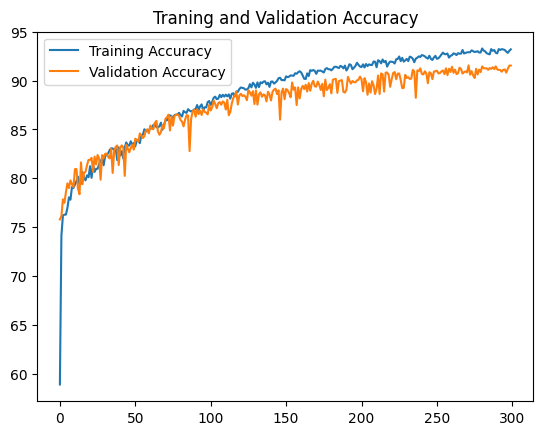

In [ ]:
# Model Parameters
hidden_dim = 16
n_layers = 2
n_heads = 1
dropout = 0.5

# Training and Optimizer Parameters
lr = 0.0008
num_epochs = 300
weight_decay = 2e-2
beta_1 = 0.85
beta_2 = 0.92

if len(X_train.shape) > 2:
    input_dim = X_train.shape[2] # If Glove twitter50 embeddings
else: 
    input_dim = X_train.shape[1] # If bert embeddings


# Transformer Classifier Model
model = TransformerClassifier(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers, n_heads=n_heads, dropout=dropout)

# Binary Cross Entropy as Loss function
criterion = t.nn.BCEWithLogitsLoss(pos_weight=((Y_train == 0).sum() / (Y_train == 1).sum()))

# AdamW is the optimizer
optimizer = t.optim.AdamW(model.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)

def validate_model(model_t: t.nn.Module):
    """Return accuracy, f1 validation score of the model."""
    predictions = (model_t(X_validation) > 0.50).squeeze(1)
    accuracy = accuracy_score(Y_validation, predictions)
    return accuracy

# Main training loop
acc_history = []
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()

        x, y_batch = data

        predictions = model(x)

        loss = criterion(predictions.squeeze(1), y_batch.float())
        
        predicted = t.round(predictions.squeeze(1))
        correct += (predicted == y_batch).sum().item() 
        total += train_dataloader.batch_size

        loss.backward()

        optimizer.step()

    model.eval()
    train_acc = 100 * correct / total
    validation_acc = 100 * validate_model(model)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {validation_acc:.2f}")
    acc_history.append((train_acc, validation_acc))
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {validation_acc:.2f}")


plt.title("Traning and Validation Accuracy")
plt.plot([a[0] for a in acc_history])
plt.plot([a[1] for a in acc_history])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Final Evaluation of the model

### Loading the test data

In [ ]:
test_data = pd.read_csv("a3_test.tsv", sep="\t", names=["target", "text"])   # ska vi inte använda get_transformed_data?
X_text_test = np.array(test_data["text"].values)
Y_test = t.tensor(test_data["target"].values, dtype=t.long)
X_test = bert_transform(list(X_text_test))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timbakkenes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploring the distribution of the test data

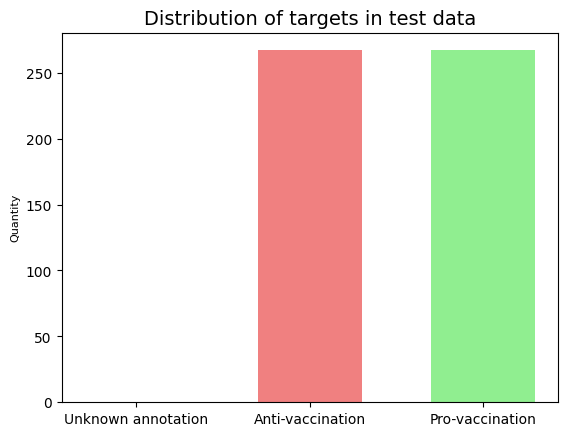

In [ ]:

X_2 = np.array(test_data["text"].values)

Y_2 = list(test_data["target"].values)

unknown_annotation_test = 0
target_0_test = 0
target_1_test = 0
for target_test in Y_2:
    if target_test == -1:
        unknown_annotation_test +=1 
    elif target_test == 0:
        target_0_test +=1 
    else: 
        target_1_test +=1

values_test = [unknown_annotation_test, target_0_test, target_1_test]
categories_test = ["Unknown annotation", "Anti-vaccination", "Pro-vaccination"]

colors_test = ["grey", "lightcoral", "lightgreen"]
plt.bar(categories_test, values_test, color=colors_test, width=0.6)
#plt.xlabel("Annotations of data", fontsize=8)
plt.ylabel("Quantity", fontsize=8)
plt.title("Distribution of targets in test data", fontsize=14)
plt.show()

### Evaluating model on test data

Test accuracy: 83.52059721946716
Test F1: 0.8376383763837639
Test Recall: 0.850187265917603
Test Precision: 0.8254545454545454


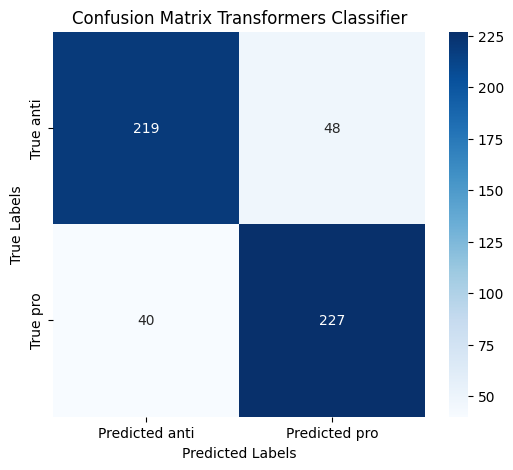

In [ ]:
model.eval()
predictions = (model(X_test) > 0.5).squeeze(1)
test_acc = 100 * ((predictions == Y_test).sum() / Y_test.shape[0]).item()
print(f"Test accuracy: {test_acc}")
print(f"Test F1: {f1_score(Y_test, predictions)}")
print(f"Test Recall: {recall_score(Y_test, predictions)}")
print(f"Test Precision: {precision_score(Y_test, predictions)}")


cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted anti', 'Predicted pro'], yticklabels=['True anti', 'True pro'])
plt.title('Confusion Matrix Transformers Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("images/results_confusion.png", dpi=200)
plt.show()

In [ ]:
# Find incorrect predictions
wrong_indices = np.where(predictions.cpu().numpy() != Y_test.cpu().numpy())[0]
wrong_preds = predictions[wrong_indices]
actual_values = Y_test[wrong_indices]

print("Example misclassified texts:")
for i in range(min(5, len(wrong_indices))):  
    print(f"Text: {X_text_test[wrong_indices[i]]}")
    print(f"Predicted: {wrong_preds[i].item()}, Actual: {actual_values[i].item()}\n")

Example misclassified texts:
Text: Extremely rare is only good if it doesn't happen to you. It's not the job of medical researchers to decide if the risk is worth it. The decision needs to rest with the patient who is assuming the risk. And coercion from the medical and political authorities prevents proper informed consent because you aren't really consenting if you will be punished for refusing consent.
Predicted: True, Actual: 0

Text: Not getting vaccinated is still more dangerous. Uh-huh. Right.
Predicted: True, Actual: 0

Text: Advance R.I.P. to those who will take covid vaccines.
Predicted: True, Actual: 0

Text: After I got my vaccines, I had terrible side-effects. Painful headaches, body soreness, and fatigue. Basically they made a whole day for me miserable.
Predicted: True, Actual: 0

Text: Ah crap I got polio. BuT AtlEaST i dOnT haVE AutIsM
Predicted: False, Actual: 1



### Comparing with Trivial Baseline

The Scikit-learn Dummyclassifier was chosen as the trivial baseline. It predicts the label that is the most frequent. 

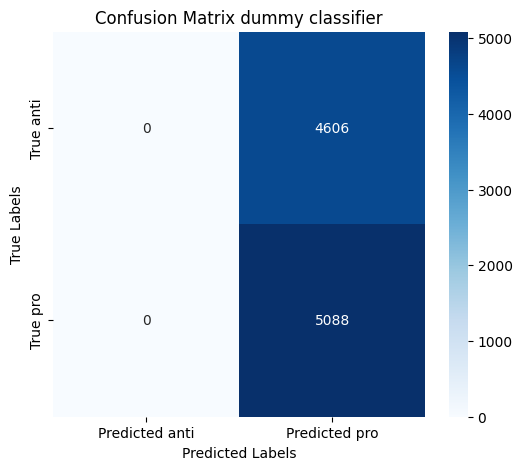

Accuracy score: 52.49%
F1 score: 68.84%


In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, Y_train)

dummy_predictions = dummy_clf.predict(X_validation)

accuracy_dummy = accuracy_score(Y_validation, dummy_predictions)
precision_dummy = precision_score(Y_validation, dummy_predictions)
recall_dummy = recall_score(Y_validation, dummy_predictions)
f1_dummy = f1_score(Y_validation, dummy_predictions)
cm_dummy = confusion_matrix(Y_validation, dummy_predictions)
tp_dummy, tn_dummy, fp_dummy, fn_dummy = cm_dummy.ravel()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted anti', 'Predicted pro'], yticklabels=['True anti', 'True pro'])
plt.title('Confusion Matrix dummy classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(f"Accuracy score: {100*accuracy_dummy:.2f}%")
print(f"F1 score: {100 *f1_dummy:.2f}%")